<a href="https://colab.research.google.com/github/frschboyy/APT3095PROJ/blob/main/finslProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install streamlit
!pip install pyngrok


In [14]:
%%writefile app.py
import streamlit as st

st.title('Hello Streamlit!')
st.write('Welcome to Streamlit on Colab!')


Overwriting app.py


In [ ]:
from pyngrok import ngrok

!streamlit run app.py

# Open a HTTP tunnel on the default Streamlit port 8501
# public_url = ngrok.connect(port='8501')
print('Streamlit app is live at:', 'ngrok http http://localhost:8080')




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.199.167.163:8501



In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import zipfile
import os

import seaborn as sns
from re import M
from copy import deepcopy
import pandas as pd

import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import LinearSegmentedColormap

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/datasets/dataset.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

# **`Data Visualization`**

In [2]:
# Load raw RNFLT map data
map_set = np.load("/content/Dataset/rnflt_map.npy")
# Load additional data containing corresponding labels and mean deviation
md_set = np.load("/content/Dataset/visual_field_md.npy")
label_set = np.load("/content/Dataset/glaucoma_label.npy")

In [3]:
# Read and process dataset in batches
def process_batch(start, end, num):
  values = []
  for i in range(start, end):
    img = map_set[i] # get image from dataset
    flattened_image = img.flatten() # flatten image
    values.extend(flattened_image) # add flattened image to values list
  print(f"Batch {num} processed")
  return values

Batch 1 processed
Batch 2 processed
Batch 3 processed
Batch 4 processed
Batch 5 processed
Batch 6 processed
Batch 7 processed
Batch 8 processed
Batch 9 processed
Batch 10 processed
Batch 11 processed
Batch 12 processed
Batch 13 processed
Batch 14 processed
Batch 15 processed
Batch 16 processed


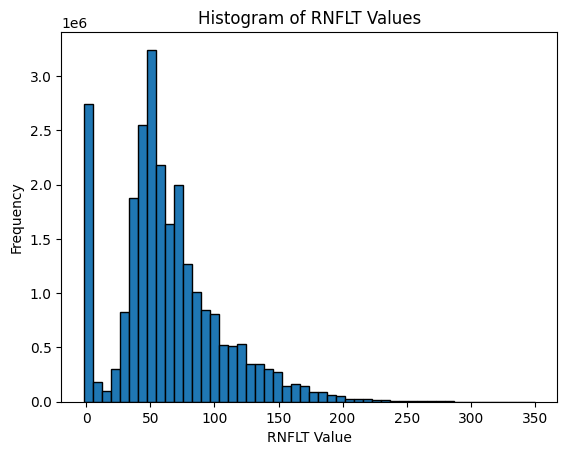

In [4]:
# Flatten each RNFLT map and plot a histogram of the pixel values
size = map_set.shape[0]
batch_size = 32

# Initialize list to store flattened values
values = []

count = 1
for i in range(0, size, batch_size):
  start_index = i
  end_index = min(i + batch_size, size)
  batch_values = process_batch(start_index, end_index, count)
  values.extend(batch_values) # Collect all values from current batch
  count += 1

plt.hist(values, bins=50, edgecolor='black')
plt.xlabel('RNFLT Value')
plt.ylabel('Frequency')
plt.title('Histogram of RNFLT Values')
plt.show()

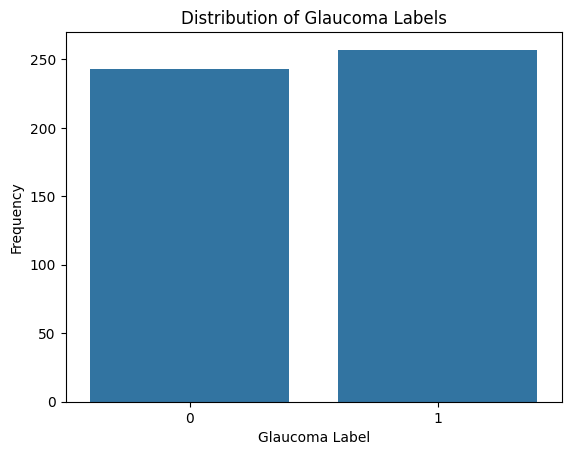

In [5]:
# Visualize distribution of glaucoma labels
sns.countplot(x=label_set)
plt.xlabel('Glaucoma Label')
plt.ylabel('Frequency')
plt.title('Distribution of Glaucoma Labels')
plt.show()

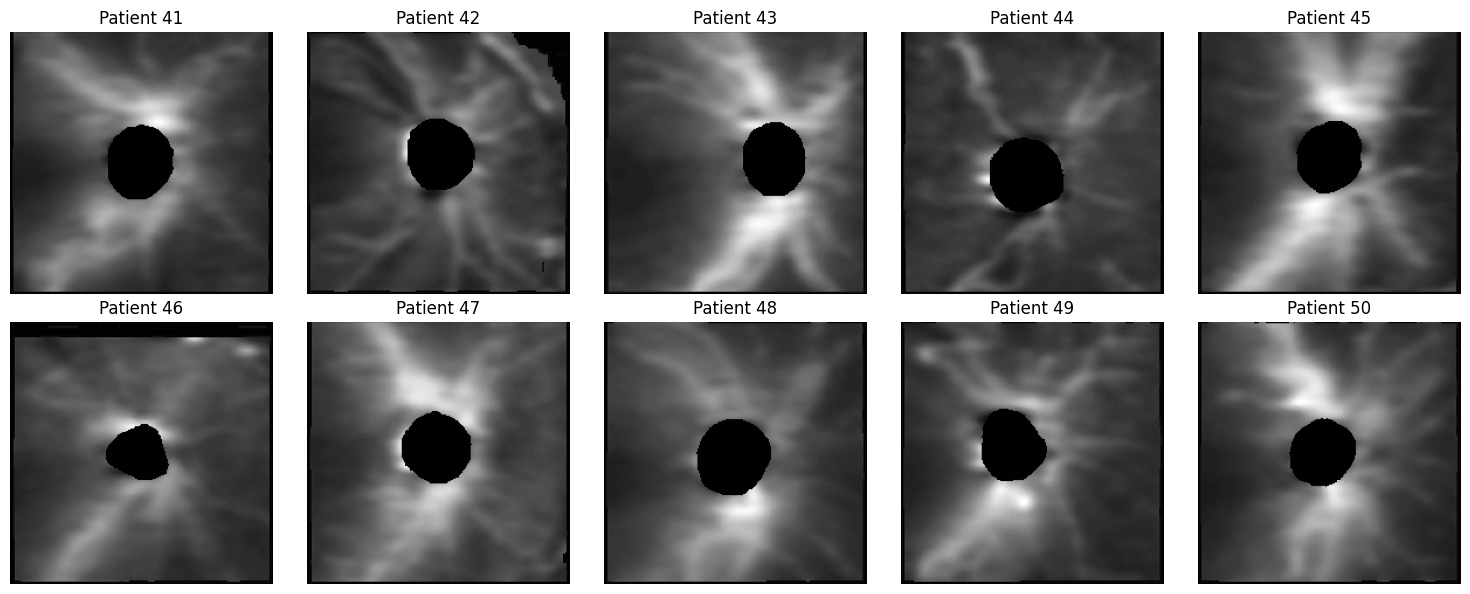

In [48]:
# Inspect a few RNFLT maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(map_set[i+40], cmap='gray')
    ax.set_title(f'Patient {i+1+40}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# **`Data Preprocessing`**

In [69]:
# convert a 2D image into a 3D image using colormap
def to_3dmap(img, cm=None, N=10000):
    if cm == None:
      # generate color map
      cm = LinearSegmentedColormap.from_list( # Use colors.LinearSegmentedColormap
          "", [(0,'black'),(0.06,'blue'),(0.23, '#2ab6c6')
          , (0.38,'yellow'),(0.6,'red'), (1,'white')], N=10000)

    img[img>350] = 350 # Clip values above 350 to 350

    # Normalizes image to [0, 1] range by dividing by 350
    img_colored = cm((img/350.0)) # Apply colormap to map normalize valies to colors

    # Extract RGB and convert to 8-bit unsigned integer
    colored_image = (img_colored[:, :, :3] * 255).astype(np.uint8)

    return colored_image

# Image augmentation
def random_tranformation(img, type=0):
  img_size = img.shape[0]

  if type == 0: # Random crop center
    ratio = np.random.uniform(0, 0.2)
    cropsize = int(img_size*ratio)
    img = img[cropsize:(img_size-cropsize), cropsize:(img_size-cropsize), :]
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_NEAREST)
  elif type == 1: # Random rotation (-45° => 45°)
    angle = np.random.uniform(-45, 45)
    M = cv2.getRotationMatrix2D((img_size/2, img_size/2), angle, 1)
    img = cv2.warpAffine(img, M, (img_size, img_size), flags=cv2.INTER_NEAREST)
  elif type == 2: # Zoom in or out (0% => 20%)
    zx, zy = np.random.uniform(0.8, 1.2, 2)
    M = np.array([[zx, 0, 0], [0, zy, 0]], dtype=np.float32)
    img = cv2.warpAffine(img, M, (img_size, img_size), flags=cv2.INTER_NEAREST)
  elif type == 3: # Height shift
    ty = np.random.uniform(-0.2, 0.2)
    M = np.array([[1, 0, 0], [0, 1, ty * img_size]], dtype=np.float32)
    img = cv2.warpAffine(img, M, (img_size, img_size), flags=cv2.INTER_NEAREST)

  if img.shape != (img_size, img_size, 3):
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

  return img

# Batch Processing
def process_batch(start, end, batch_num):
  kernel = np.ones((4,4), np.uint8)  # Initialize kernel for morphological operations
  margin = 3  # Margin to be removed from each image

  # Initialize arrays for storing processed images and additional info
  maps = []
  mds = []
  labls = []

  # Load raw RNFLT map data
  all_maps = np.load("/content/Dataset/rnflt_map.npy")
  # Load additional data containing corresponding labels and mean deviation
  all_mds = np.load("/content/Dataset/visual_field_md.npy")
  all_labels = np.load("/content/Dataset/glaucoma_label.npy")

  count = 0

  # Iterate through every image in the current batch
  for i in range(start, end):
    update = all_maps[i][margin:-margin, margin:-margin]  # Cropped version of image
    update = cv2.morphologyEx(update, cv2.MORPH_CLOSE, kernel)  # Remove small holes and noise
    update = cv2.resize(update, (256, 256))  # Set standard image size

    update = update.astype(np.uint8)  # Convert to uint8 if it's not already

    update = cv2.medianBlur(update, 3)  # Remove noise using median blur
    update = cv2.GaussianBlur(update, (3, 3), 0)  # Repair image using Gaussian blur

    # Inpainting: Create a mask for dark spots
    _, thresholded = cv2.threshold(update, 10, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.dilate(thresholded, None, iterations=3)
    mask = cv2.resize(mask, (all_maps[i].shape[1], all_maps[i].shape[0])) # Resize mask to match original image

    # Ensure both image and mask are 8-bit single-channel for inpainting
    all_maps_i_gray = cv2.cvtColor(all_maps[i], cv2.COLOR_BGR2GRAY) if len(all_maps[i].shape) == 3 else all_maps[i] # Convert to grayscale if it's a 3-channel image
    all_maps_i_gray = all_maps_i_gray.astype(np.uint8)  # Ensure 8-bit format
    mask = mask.astype(np.uint8)  # Ensure 8-bit format

    # Inpainting to repair dark spots
    update = cv2.inpaint(all_maps_i_gray, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    new_img = to_3dmap(update, N=256)  # Convert to 3D image

    # Ensure all images are resized to the same shape
    if new_img.shape != (256, 256, 3):
      # print(f"Image shape mismatch: {new_img.shape}")
      new_img = cv2.resize(new_img, (256, 256), interpolation=cv2.INTER_NEAREST)

    # print(f"Image shape: {new_img.shape}")

    new_img = new_img  # Normalize image
    new_img = new_img.astype(np.uint8)

    maps.append(new_img)  # Add images to maps array
    mds.append(all_mds[i])
    labls.append(all_labels[i])
    count += 1

    # Create and add 4 augmented versions of image to dataset
    for j in range(4):
      aug_img = random_tranformation(new_img.copy(), type=j)
      # print(f"Aug shape: {new_img.shape}")
      if aug_img.shape != (256, 256, 3):
        aug_img = cv2.resize(aug_img, (256, 256), interpolation=cv2.INTER_NEAREST)

      # aug_img / 255.0  # Normalize augmented images
      aug_img = aug_img.astype(np.uint8)  # Ensure image type is uint8

       # Check shape before appending
      # if aug_img.shape != (256, 256, 3):
      #   print(f"Augmented image shape mismatch: {aug_img.shape}")

      maps.append(aug_img)
      mds.append(all_mds[i])
      labls.append(all_labels[i])
      count += 1

  # Convert lists to NumPy arrays after ensuring shape consistency
  maps = np.array(maps)
  mds = np.array(mds)
  labls = np.array(labls)

  # Ensure maps array has consistent shape
  if maps.shape[1:] != (256, 256, 3):
    # print(f"Final maps array shape mismatch: {maps.shape}")
    raise ValueError(f"Maps array has inconsistent shape: {maps.shape}")

  # # Create list of indices based on the maps dataset and shuffle them
  # ids = np.arrange(len(maps))
  # np.random.shuffle(ids)

  # maps = np.array(maps)[ids]
  # mds = np.array(mds)[ids]
  # labls = np.array(labls)[ids]

  print(f"\nBatch {batch_num} (Processed {count / 5} images)")

  return maps, mds, labls

In [98]:
# Initialize arrays for storing processed images and additional info
all_maps = []
all_mds = []
all_labls = []

count = 1
for i in range(0, size, batch_size):
  start_index = i
  end_index = min(i + batch_size, size)
  maps, mds, labls = process_batch(start_index, end_index, count)
  all_maps.append(maps)
  all_mds.append(mds)
  all_labls.append(labls)
  count += 1

# Convert lists to NumPy arrays
all_maps = np.concatenate(all_maps)
all_mds = np.concatenate(all_mds)
all_labls = np.concatenate(all_labls)

# Shuffle datasets
ids = np.arange(len(all_maps))
np.random.shuffle(ids)

all_maps = all_maps[ids]
all_mds = all_mds[ids]
all_labls = all_labls[ids]

# Save datasets and additional information
np.save("/content/Dataset/maps.npy", all_maps)
np.save("/content/Dataset/mds.npy", all_mds)
np.save("/content/Dataset/labls.npy", all_labls)

<ipython-input-69-314c4a23cd19>:9: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 350 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img[img>350] = 350 # Clip values above 350 to 350



Batch 1 (Processed 32.0 images)

Batch 2 (Processed 32.0 images)

Batch 3 (Processed 32.0 images)

Batch 4 (Processed 32.0 images)

Batch 5 (Processed 32.0 images)

Batch 6 (Processed 32.0 images)

Batch 7 (Processed 32.0 images)

Batch 8 (Processed 32.0 images)

Batch 9 (Processed 32.0 images)

Batch 10 (Processed 32.0 images)

Batch 11 (Processed 32.0 images)

Batch 12 (Processed 32.0 images)

Batch 13 (Processed 32.0 images)

Batch 14 (Processed 32.0 images)

Batch 15 (Processed 32.0 images)

Batch 16 (Processed 20.0 images)


# Data Visualization

In [ ]:
# # Load preprocessed RNFLT maps
# map_set = np.load("/content/Dataset/maps.npy")

# # Flatten the images and plot histogram to analysze distrubtion
# values_after = []

# batch_size = 10

# count = 1
# for i in range(0, size, batch_size):
#   start_index = i
#   end_index = min(i + batch_size, size)
#   batch_values = process_batch(start_index, end_index, count)
#   values.extend(batch_values) # Collect all values from current batch
#   count += 1

# plt.hist(values, bins=50, edgecolor='black')
# plt.xlabel('RNFLT Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of RNFLT Values (After Preprocessing)')
# plt.show()


Batch 1 (Processed 10.0 images)

Batch 2 (Processed 10.0 images)

Batch 3 (Processed 10.0 images)

Batch 4 (Processed 10.0 images)

Batch 5 (Processed 10.0 images)

Batch 6 (Processed 10.0 images)

Batch 7 (Processed 10.0 images)

Batch 8 (Processed 10.0 images)

Batch 9 (Processed 10.0 images)

Batch 10 (Processed 10.0 images)

Batch 11 (Processed 10.0 images)

Batch 12 (Processed 10.0 images)

Batch 13 (Processed 10.0 images)

Batch 14 (Processed 10.0 images)

Batch 15 (Processed 10.0 images)

Batch 16 (Processed 10.0 images)

Batch 17 (Processed 10.0 images)

Batch 18 (Processed 10.0 images)

Batch 19 (Processed 10.0 images)

Batch 20 (Processed 10.0 images)

Batch 21 (Processed 10.0 images)

Batch 22 (Processed 10.0 images)

Batch 23 (Processed 10.0 images)

Batch 24 (Processed 10.0 images)

Batch 25 (Processed 10.0 images)

Batch 26 (Processed 10.0 images)

Batch 27 (Processed 10.0 images)

Batch 28 (Processed 10.0 images)

Batch 29 (Processed 10.0 images)

Batch 30 (Processed 10

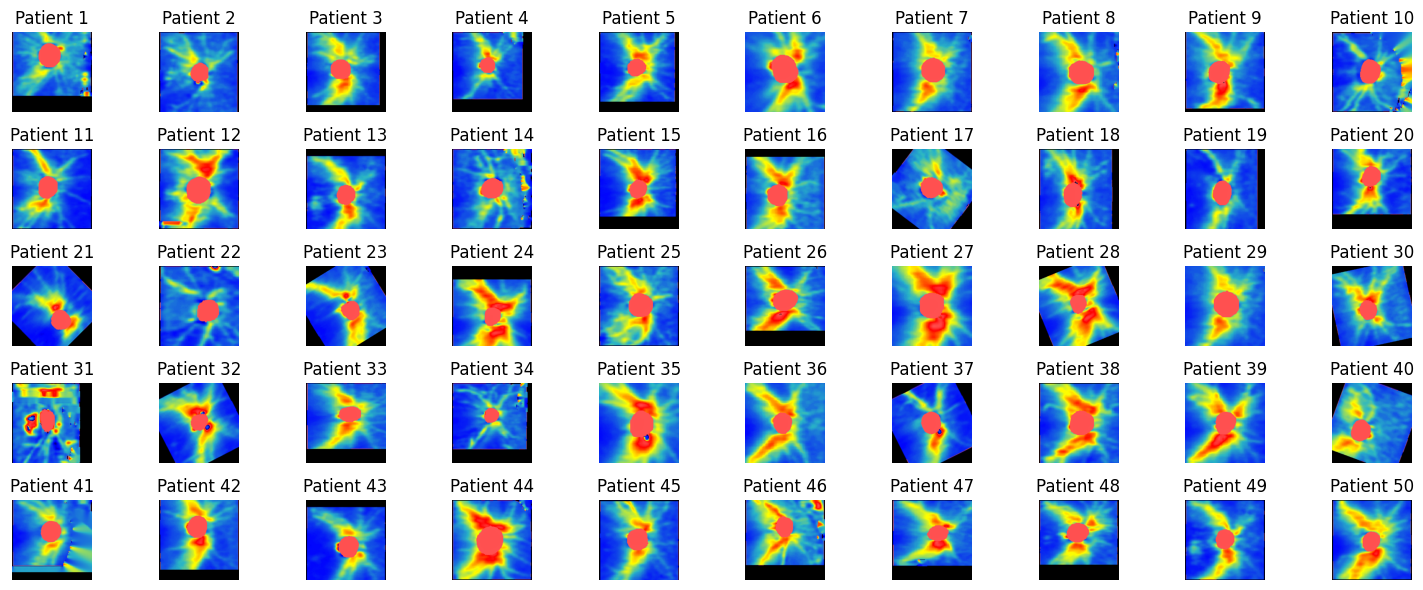

In [71]:
# Visualizing some processed RNFLT Maps
fig, axes = plt.subplots(5, 10, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(all_maps[i])
    ax.set_title(f'Patient {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

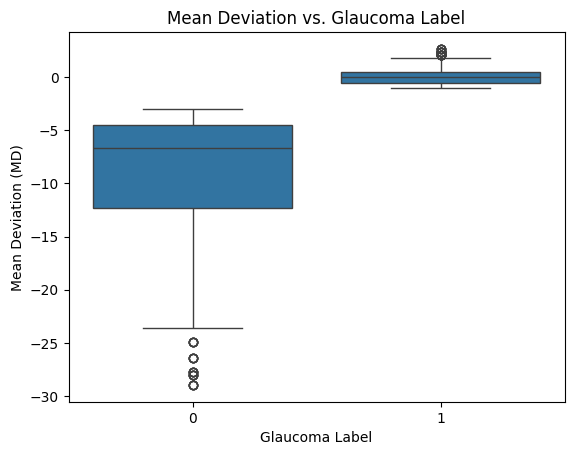

In [10]:
# Investigate the relationship between glaucoma status and visual field mean deviation
df = pd.DataFrame({
    'MD': all_mds,
    'Glaucoma Label': all_labls
})

sns.boxplot(x='Glaucoma Label', y='MD', data=df)
plt.title('Mean Deviation vs. Glaucoma Label')
plt.xlabel('Glaucoma Label')
plt.ylabel('Mean Deviation (MD)')
plt.show()


*   Non-overlapping IQRs suggest strong relationship between MD and the Glaucoma Status.
*   The noticeable difference in median also suggests a strong relationship between MD and the Glaucoma

# **# `Define Model Architecture and Compile`**

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential([
    # Convolutional layers for feature extraction
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Flattens the maps into a 1D vector
    Dense(128, activation='relu'),
    Dropout(0.5), # Adding dropout layer to reduce overfitting
    Dense(1, activation='sigmoid') # Sigmoid layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='binary_crossentropy', # used for binary clasffication
    metrics=['accuracy'])

In [ ]:
# Split dataset into training and validation sets

# Load RNFLT map data
process_maps = np.load("/content/Dataset/maps.npy")
# Load additional data containing corresponding labels and mean deviation
process_mds = np.load("/content/Dataset/mds.npy")
process_labls = np.load("/content/Dataset/labls.npy")

# train_size = int(0.8 * len(process_maps))
# val_size = len(process_maps) - train_size

# define training datasets
train_maps = process_maps[:2000]
train_mds = process_mds[:2000]
train_labls = process_labls[:2000]

# define validation dataset
val_maps = process_maps[2000:]
val_mds = process_mds[2000:]
val_labls = process_labls[2000:]

# Train Model

In [106]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')

history = model.fit(train_maps, train_labls,
                    epochs=9 ,
                    batch_size=32,
                    validation_data=(val_maps, val_labls),
                    verbose=1)

Epoch 1/9
63/63 [==============================] - 6s 71ms/step - loss: 14.4583 - accuracy: 0.6410 - val_loss: 0.5184 - val_accuracy: 0.7900
Epoch 2/9
63/63 [==============================] - 4s 64ms/step - loss: 0.4898 - accuracy: 0.7735 - val_loss: 0.4574 - val_accuracy: 0.7820
Epoch 3/9
63/63 [==============================] - 4s 63ms/step - loss: 0.4548 - accuracy: 0.7920 - val_loss: 0.4688 - val_accuracy: 0.7860
Epoch 4/9
63/63 [==============================] - 4s 66ms/step - loss: 0.4018 - accuracy: 0.8215 - val_loss: 0.4328 - val_accuracy: 0.7940
Epoch 5/9
63/63 [==============================] - 4s 65ms/step - loss: 0.3865 - accuracy: 0.8245 - val_loss: 0.4090 - val_accuracy: 0.8100
Epoch 6/9
63/63 [==============================] - 4s 64ms/step - loss: 0.3542 - accuracy: 0.8345 - val_loss: 0.4700 - val_accuracy: 0.7720
Epoch 7/9
63/63 [==============================] - 4s 66ms/step - loss: 0.3236 - accuracy: 0.8520 - val_loss: 0.4474 - val_accuracy: 0.8160
Epoch 8/9
63/63 [==

Fine Tuning

The Past Version of the model were overfitting. This is likely due to the data to epoch ratio.


*   I started at 25 epochs, but I noticed that after around 10 epochs, the validation loss began to increase, while the train accuracy began to increase. This meant that the model was overfamiliarizing itself with the training dataset impairing the models ability to generalize.


*   I modified the dataset I was using in a previous instance of my model. Initially, many images had dark spots, which limited the models ability to learn effectively. I leveraged Inpainting technique is used to reconstruct each image to fill in dark spots based on surroundings. My validation accuracy increased from around 7.7 to 8.0


*   I included a third Convolution Layer in hopes of improving model accuracy, especially with regards to validation accuracy. I was able to bump valition accuracy of model to 8.2





# Evaluate Model

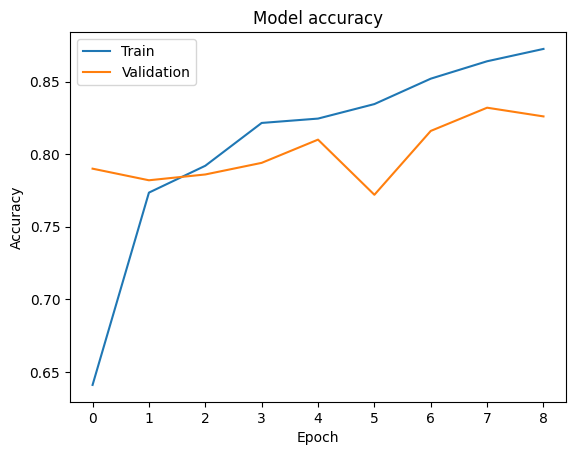

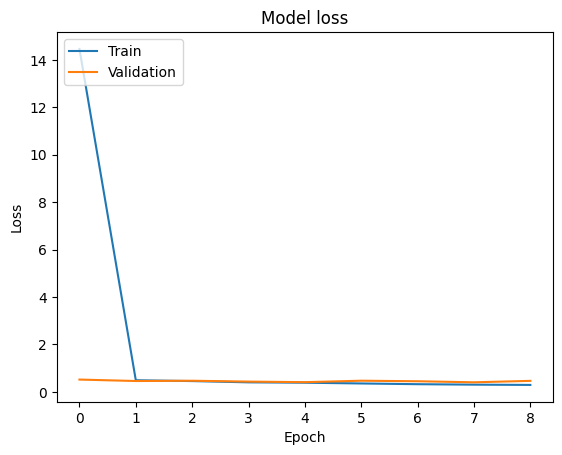

In [107]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [109]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [111]:
model.save('my_model.keras')

In [10]:
# Check if the file exists
import os
if os.path.exists('/content/my_model.keras'):
  print("File exists")
else:
  print("File does not exist. Check the file path or ensure the model was saved correctly.")

# Try loading the model with error handling
try:
  new_model = tf.keras.models.load_model('/content/my_model.keras')
  # Show model architecture
  new_model.summary()
except OSError as e:
  print(f"Error loading the model: {e}")

File exists
Error loading the model: Unable to synchronously open file (file signature not found)


In [114]:
# Evaluate the restored model
loss, acc = new_model.evaluate(val_maps, val_labls, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# Predict on the validation data (val_maps), not the labels
predictions = new_model.predict(val_maps).shape
print(predictions)

16/16 - 0s - loss: 0.4642 - accuracy: 0.8260 - 345ms/epoch - 22ms/step
Restored model, accuracy: 82.60%
16/16 [==============================] - 0s 15ms/step
(500, 1)


In [8]:
from flask import Flask, request, jsonify

app = Flask(__name__)

new_model = tf.keras.models.load_model('/content/my_model.keras')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Preprocess data if needed
    input_data = preprocess(data)
    # Make predictions
    predictions = new_model.predict(input_data)
    # Postprocess results if needed
    results = postprocess(predictions)
    return jsonify(results)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

OSError: Unable to synchronously open file (file signature not found)